# Convolutional Neural Networks

* Introducing and Preparing the Fashion MNIST Dataset
* Custom Convolutional Layer Implementation
* Using Built-in Conv2d Layers
* Using a Pre-trained EfficientNet-B0 Model

Here's a brief overview of each section:

1. Dataset Preparation:

* We load the Fashion MNIST dataset using torchvision.
* We apply transformations to normalize the data.
* We create DataLoaders for efficient batch processing.
* There's a function to visualize some sample images from the dataset.


2. Custom Convolutional Layer:

* We implement a custom CustomConv2d class that explicitly performs the convolution operation.
* We create a CustomCNN model using these custom convolutional layers.
* We define a training loop and train the custom model.


3. Built-in Conv2d Layers:

* We create a CNNWithBuiltInLayers class using PyTorch's built-in nn.Conv2d layers.
* We train this model using the same training loop.


4. Pre-trained EfficientNet-B0:

* We import the pre-trained EfficientNet-B0 model from torchvision.models.
* We modify the first layer to accept grayscale images and the last layer to output 10 classes.
* We train this model on our Fashion MNIST dataset.



5. Finally, we evaluate and compare the performance of all three models on the test set.

In [1]:
# Import necessary libraries and modules

# PyTorch core libraries
import torch  # Main PyTorch library for tensor computations and neural networks
import torch.nn as nn  # Neural network modules and layers
import torch.nn.functional as F  # Functional interface for neural network operations
import torch.optim as optim  # Optimization algorithms for training neural networks

# Computer vision and image processing libraries
import torchvision  # PyTorch library for computer vision tasks
import torchvision.transforms as transforms  # Image transformation and augmentation utilities

# Data handling utilities
from torch.utils.data import DataLoader, Subset  # Tools for efficient data loading and subset creation

# Visualization libraries
import matplotlib.pyplot as plt  # For creating plots and visualizations
import numpy as np  # For numerical operations and array manipulations

# Model summary tool
from torchsummary import summary  # Utility for displaying neural network architecture summaries

# 1. Introducing and Preparing the Fashion MNIST Dataset

100%|██████████| 26421880/26421880 [00:08<00:00, 3157354.41it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 143343.00it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 617854.07it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 26299971.98it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



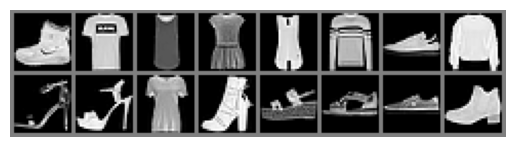

In [2]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image or numpy.ndarray to tensor (H x W x C) in range [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,))  # Normalizes tensor with mean and standard deviation
])
# The Normalize transform adjusts pixel values to have mean 0 and std 1
# Formula: (x - mean) / std
# Here, it maps [0, 1] to [-1, 1] for each channel

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
classes = test_dataset.classes  # Get class labels

# Limit the number of training examples
num_train_examples = 1000  # Adjust this to change dataset size
train_subset = Subset(train_dataset, range(num_train_examples))  # Create a subset of the training data

# Create data loaders for efficient batching and shuffling
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to visualize images
def show_images(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)  # Get a batch of images
    img = torchvision.utils.make_grid(images[:16])  # Create a grid of 16 images
    img = img / 2 + 0.5  # Unnormalize the images (reverse the normalization)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display
    # (1, 2, 0) changes the order from (C, H, W) to (H, W, C) for matplotlib
    plt.axis('off')
    plt.show()

# Display a sample of training images
show_images(train_loader)

# 2. Custom Convolutional Layer

**Convolution operation**

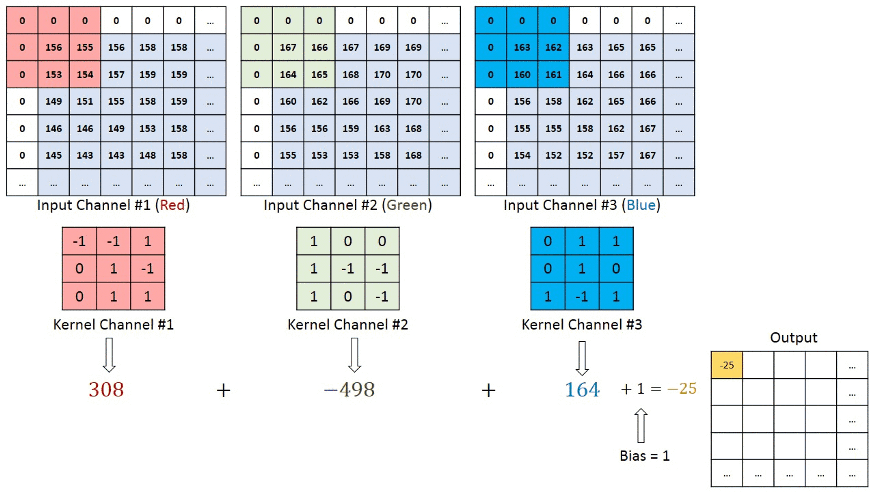

**Pooling operation**

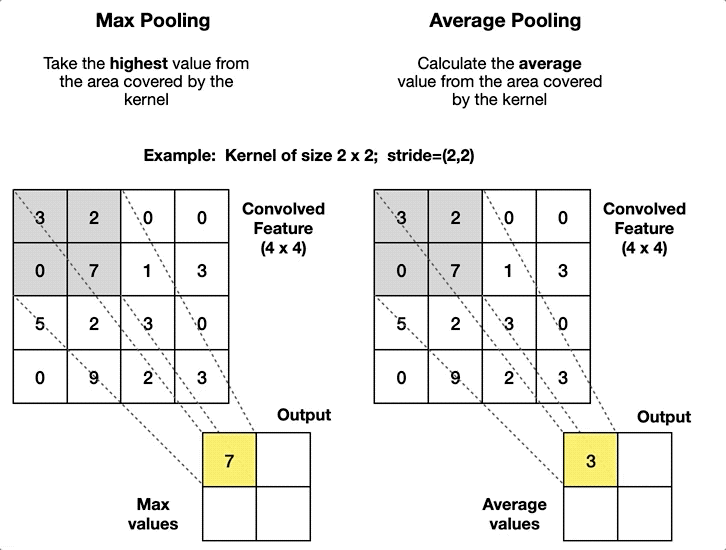

In [3]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        # Initialize the custom 2D convolutional layer
        super(CustomConv2d, self).__init__()

        # Store input parameters
        self.in_channels = in_channels    # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.kernel_size = kernel_size    # Size of the convolutional kernel
        self.stride = stride              # Stride of the convolution
        self.padding = padding            # Padding added to input

        # Initialize learnable parameters
        # Weight shape: (out_channels, in_channels, kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        # Bias shape: (out_channels,)
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        # Perform the forward pass of the convolutional layer
        device = x.device  # Get the device (CPU/GPU) of the input
        # Print the GPU device if available
        if device.type == 'cuda':
            print(f'Running on GPU: {device}')
        else:
            print('Running on CPU')

        # Ensure weights and biases are on the same device as input
        weight = self.weight.to(device)
        bias = self.bias.to(device)

        # Get input dimensions
        batch_size, _, height, width = x.size()

        # Apply padding to input
        x = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Calculate output dimensions
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1

        # Initialize output tensor
        out = torch.zeros(batch_size, self.out_channels, out_height, out_width, device=device)

        # Perform convolution operation
        for b in range(batch_size):
            for c_out in range(self.out_channels):
                for h in range(out_height):
                    for w in range(out_width):
                        # Define the receptive field
                        h_start, w_start = h * self.stride, w * self.stride
                        h_end, w_end = h_start + self.kernel_size, w_start + self.kernel_size

                        # Extract receptive field
                        receptive_field = x[b, :, h_start:h_end, w_start:w_end]

                        # Compute convolution for this position
                        # 1. Element-wise multiplication of receptive field and kernel
                        # 2. Sum all elements
                        # 3. Add bias
                        out[b, c_out, h, w] = torch.sum(receptive_field * weight[c_out]) + bias[c_out]

        return out  # Return the output tensor

# Custom CNN Model with Vectorized Implementation

In [5]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        # Initialize the custom 2D convolutional layer
        super(CustomConv2d, self).__init__()

        # Store layer parameters
        self.in_channels = in_channels    # Number of input channels
        self.out_channels = out_channels  # Number of output channels
        self.kernel_size = kernel_size    # Size of the convolutional kernel
        self.stride = stride              # Stride of the convolution
        self.padding = padding            # Padding added to input

        # Initialize learnable parameters
        # Weight shape: (out_channels, in_channels, kernel_size, kernel_size)
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        # Bias shape: (out_channels,)
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        # Apply padding to input
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        # Get input dimensions
        batch_size, in_channels, in_height, in_width = x.shape

        # Calculate output dimensions
        out_height = (in_height - self.kernel_size) // self.stride + 1
        out_width = (in_width - self.kernel_size) // self.stride + 1

        # Reshape input for vectorized convolution
        # This creates sliding local views of the input tensor
        x_reshaped = x.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        # Reshape to (batch_size, in_channels, out_height, out_width, kernel_size^2)
        x_reshaped = x_reshaped.contiguous().view(batch_size, in_channels, out_height, out_width, -1)

        # Perform convolution using batch matrix multiplication
        # 1. Unsqueeze x_reshaped to add out_channels dimension
        # 2. Reshape weight to (out_channels, in_channels, kernel_size^2)
        # 3. Unsqueeze weight to match x_reshaped dimensions
        # 4. Perform element-wise multiplication and sum over in_channels and kernel dimensions
        out = (x_reshaped.unsqueeze(1) * self.weight.view(self.out_channels, self.in_channels, -1)
               .unsqueeze(2).unsqueeze(2).unsqueeze(0)).sum(dim=[2, -1])

        # Add bias
        out += self.bias.view(1, -1, 1, 1)

        return out  # Return the output tensor

In [6]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=5):
    # Set model to training mode
    model.train()
    total_batches = len(train_loader)

    # Lists to store epoch-wise average loss and accuracy
    avg_los = []
    accuracy = []

    for epoch in range(num_epochs):
        # Initialize metrics for each epoch
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Iterate over batches in the training data
        for i, (inputs, labels) in enumerate(train_loader):
            # Move inputs and labels to the specified device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update running loss
            running_loss += loss.item()

            # Print statistics every 10 batches
            if (i + 1) % 10 == 0:
                batch_accuracy = 100 * correct_predictions / total_predictions
                avg_loss = running_loss / 10
                print(f"Batch {i+1}/{total_batches} | Loss: {avg_loss:.4f} | Accuracy: {batch_accuracy:.2f}%")
                running_loss = 0.0
                correct_predictions = 0
                total_predictions = 0

        # Calculate epoch-level statistics
        model.eval()  # Set model to evaluation mode
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                epoch_total += labels.size(0)
                epoch_correct += (predicted == labels).sum().item()

        # Calculate and print epoch summary
        epoch_accuracy = 100 * epoch_correct / epoch_total
        epoch_avg_loss = epoch_loss / len(train_loader)
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Average Loss: {epoch_avg_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%")
        
        # Store epoch metrics
        avg_los.append(epoch_avg_loss)
        accuracy.append(epoch_accuracy)

        model.train()  # Set model back to training mode

    return avg_los, accuracy

In [7]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First Convolutional Layer
        # Input: 1 channel (grayscale image)
        # Output: 16 feature maps
        # Kernel size: 3x3
        # Padding: 1 (to maintain spatial dimensions)
        self.conv1 = CustomConv2d(1, 16, kernel_size=3, padding=1)

        # Second Convolutional Layer
        # Input: 16 channels (from previous layer)
        # Output: 32 feature maps
        # Kernel size: 3x3
        # Padding: 1 (to maintain spatial dimensions)
        self.conv2 = CustomConv2d(16, 32, kernel_size=3, padding=1)

        # Fully Connected Layer
        # Input: 32 * 7 * 7 (32 feature maps of size 7x7 after two max pooling operations)
        # Output: 10 (number of classes in Fashion MNIST)
        self.fc = nn.Linear(32 * 7 * 7, 10)

        # Activation Function
        # ReLU (Rectified Linear Unit) is used after each convolutional layer
        self.relu = nn.ReLU()

        # Max Pooling Layer
        # Kernel size: 2x2
        # Stride: 2 (default)
        # This halves the spatial dimensions after each convolutional layer
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # First Convolutional Block
        # 1. Apply convolution
        # 2. Apply ReLU activation
        # 3. Apply max pooling
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # Second Convolutional Block
        # 1. Apply convolution
        # 2. Apply ReLU activation
        # 3. Apply max pooling
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # Flatten the output for the fully connected layer
        # -1 in the first dimension allows for variable batch size
        x = x.view(-1, 32 * 7 * 7)

        # Fully Connected Layer
        # This produces the final output (class scores)
        x = self.fc(x)

        return x

In [8]:
# Instantiate model and perform training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
custom_model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001)

# Train the model
# You can adjust the number of epochs here if needed
num_epochs = 10  # Change this number to adjust the number of training epochs
print(f"Training on device: {device}")
print(f"Number of training examples: {num_train_examples}")
print(f"Number of epochs: {num_epochs}")
print("Starting training...")
history = train(custom_model, train_loader, criterion, optimizer, device, num_epochs=num_epochs)

Training on device: cuda
Number of training examples: 1000
Number of epochs: 10
Starting training...

Epoch 1/10
--------------------
Batch 10/16 | Loss: 26.4424 | Accuracy: 14.69%

Epoch 1 Summary:
Average Loss: 9.5510 | Accuracy: 39.10%

Epoch 2/10
--------------------
Batch 10/16 | Loss: 6.9827 | Accuracy: 52.50%

Epoch 2 Summary:
Average Loss: 3.7802 | Accuracy: 63.10%

Epoch 3/10
--------------------
Batch 10/16 | Loss: 2.5913 | Accuracy: 67.19%

Epoch 3 Summary:
Average Loss: 1.3777 | Accuracy: 77.90%

Epoch 4/10
--------------------
Batch 10/16 | Loss: 1.5551 | Accuracy: 74.38%

Epoch 4 Summary:
Average Loss: 0.9761 | Accuracy: 81.40%

Epoch 5/10
--------------------
Batch 10/16 | Loss: 1.0706 | Accuracy: 80.47%

Epoch 5 Summary:
Average Loss: 0.8537 | Accuracy: 81.10%

Epoch 6/10
--------------------
Batch 10/16 | Loss: 0.8925 | Accuracy: 80.62%

Epoch 6 Summary:
Average Loss: 0.6356 | Accuracy: 82.80%

Epoch 7/10
--------------------
Batch 10/16 | Loss: 0.5872 | Accuracy: 85.6

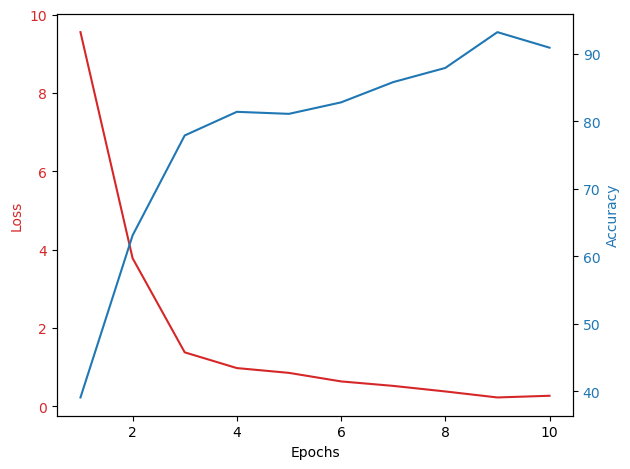

In [9]:
# Create the plot with two y-axes
fig, ax1 = plt.subplots()

# Configure and plot Loss (primary y-axis)
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.linspace(1,num_epochs,num=num_epochs), history[0], color=color)
ax1.tick_params(axis='y', labelcolor=color)
# This sets up the primary y-axis for loss, using red color
# np.linspace creates evenly spaced numbers for x-axis (epochs)
# history[0] is assumed to contain the loss values

# Create and configure secondary y-axis for Accuracy
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(np.linspace(1,num_epochs,num=num_epochs), history[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
# This sets up the secondary y-axis for accuracy, using blue color
# history[1] is assumed to contain the accuracy values

# Adjust layout and display the plot
fig.tight_layout()  # adjusts the plot to prevent label clipping
plt.show()

# Note: This code assumes:
# - 'history' is a list containing two lists: 
#   history[0] for loss values and history[1] for accuracy values
# - 'num_epochs' is defined and represents the total number of training epochs

In [10]:
print('Summary of custom_model')
summary(custom_model, (1, 28, 28))

Summary of custom_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      CustomConv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
      CustomConv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.08
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


#### Create a class with no pooling layers.
Create a class similar to CustomCNN class, but without pooling layers. Initiate the model and print the summary of the model to see the total number of parameters. Don't train the model.  

In [19]:
class CustomCNN_no_maxpool(nn.Module):
    def __init__(self):
        super(CustomCNN_no_maxpool, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # Apply convolutional layers with ReLU activation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        
        # Apply fully connected layers with ReLU activation
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the appropriate device
custom_model_no_maxpool = CustomCNN_no_maxpool().to(device)

In [20]:
print('Summary of custom_model_no_maxpool')
summary(custom_model_no_maxpool, (1, 28, 28))

Summary of custom_model_no_maxpool
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5          [-1, 128, 28, 28]          73,856
              ReLU-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 512]      51,380,736
              ReLU-8                  [-1, 512]               0
            Linear-9                   [-1, 10]           5,130
Total params: 51,478,538
Trainable params: 51,478,538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 2.69
Params size (MB): 196.38
Estimated Total Size (MB): 199.0

### 3. Using built-in Conv2d layers

In [21]:
class CNNWithBuiltInLayers(nn.Module):
    def __init__(self):
        super(CNNWithBuiltInLayers, self).__init__()
        # Define the layers
        # First conv layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        
        # Second conv layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        # Linear layer
        self.fc = nn.Linear(32 * 7 * 7, 10)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Second block
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Flatten the output
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x

# Assuming device is already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

built_in_model = CNNWithBuiltInLayers().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(built_in_model.parameters(), lr=0.001)

# Assuming train_loader and train function are defined elsewhere
history = train(built_in_model, train_loader, criterion, optimizer, device)


Epoch 1/5
--------------------
Batch 10/16 | Loss: 2.1361 | Accuracy: 31.25%

Epoch 1 Summary:
Average Loss: 1.3612 | Accuracy: 63.60%

Epoch 2/5
--------------------
Batch 10/16 | Loss: 1.1837 | Accuracy: 66.09%

Epoch 2 Summary:
Average Loss: 0.8143 | Accuracy: 71.10%

Epoch 3/5
--------------------
Batch 10/16 | Loss: 0.8164 | Accuracy: 71.41%

Epoch 3 Summary:
Average Loss: 0.6514 | Accuracy: 77.50%

Epoch 4/5
--------------------
Batch 10/16 | Loss: 0.6796 | Accuracy: 76.25%

Epoch 4 Summary:
Average Loss: 0.5717 | Accuracy: 81.40%

Epoch 5/5
--------------------
Batch 10/16 | Loss: 0.6046 | Accuracy: 80.31%

Epoch 5 Summary:
Average Loss: 0.5202 | Accuracy: 83.50%


In [22]:
print('Summary of built_in_model')
summary(built_in_model, (1, 28, 28))

Summary of built_in_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                   [-1, 10]          15,690
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.08
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


# 4. Using a pre-trained EfficientNet-B0 model


A common and highly effective approach to deep learning on small image datasets is to use a pretrained model.

If this original dataset is large enough and general enough, the spatial hierarchy of features learned by
the pretrained model can effectively act as a generic model of the visual world, and
hence, its features can prove useful for many different computer vision problems,
even though these new problems may involve completely different classes than those
of the original task.

There are two ways to use a pretrained model:
  * feature extraction and
  * fine-tuning

### Feature extraction

A CNN typically consist of a:
* Convolutional base
* Densely connected classifier

Key Idea -
* Features are learned by convolutional base. So reuse it.
* Train a new classifier for your problem

## Fine tuning

The key idea here is to fine tune some top layers of the conv base as well.

We do so by freezing most of the bottom layers, leaving only a few top layers to see

![picture](https://drive.google.com/uc?export=view&id=12FzJVGUCzQGDArYSqdABntKwKGHzIjVX)

In [23]:
import torchvision.models as models

class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(EfficientNetClassifier, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Modify the first convolutional layer to accept grayscale images
        self.efficientnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Replace the last fully connected layer
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.efficientnet(x)

# Instantiate and train the EfficientNet model
efficientnet_model = EfficientNetClassifier().to(device)
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.0001)

history  = train(efficientnet_model, train_loader, criterion, optimizer, device)

/home/pratyushk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pratyushk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/pratyushk/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:02<00:00, 9.59MB/s]



Epoch 1/5
--------------------
Batch 10/16 | Loss: 2.3188 | Accuracy: 13.91%

Epoch 1 Summary:
Average Loss: 2.3140 | Accuracy: 12.40%

Epoch 2/5
--------------------
Batch 10/16 | Loss: 2.0242 | Accuracy: 31.88%

Epoch 2 Summary:
Average Loss: 2.2876 | Accuracy: 14.00%

Epoch 3/5
--------------------
Batch 10/16 | Loss: 1.7637 | Accuracy: 49.22%

Epoch 3 Summary:
Average Loss: 1.9541 | Accuracy: 33.80%

Epoch 4/5
--------------------
Batch 10/16 | Loss: 1.5253 | Accuracy: 59.69%

Epoch 4 Summary:
Average Loss: 1.5772 | Accuracy: 54.30%

Epoch 5/5
--------------------
Batch 10/16 | Loss: 1.3573 | Accuracy: 66.09%

Epoch 5 Summary:
Average Loss: 1.2932 | Accuracy: 69.70%


In [24]:
print('Summary of efficientnet_model')
summary(efficientnet_model, (1, 28, 28))

Summary of efficientnet_model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             288
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              SiLU-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]             288
       BatchNorm2d-5           [-1, 32, 14, 14]              64
              SiLU-6           [-1, 32, 14, 14]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12           [-1, 32, 14, 14]               0
           Conv2d-13           [-1, 16, 14, 14]             512
      Bat

# Evaluate models

Custom CNN Model:
Accuracy on test set: 75.87%


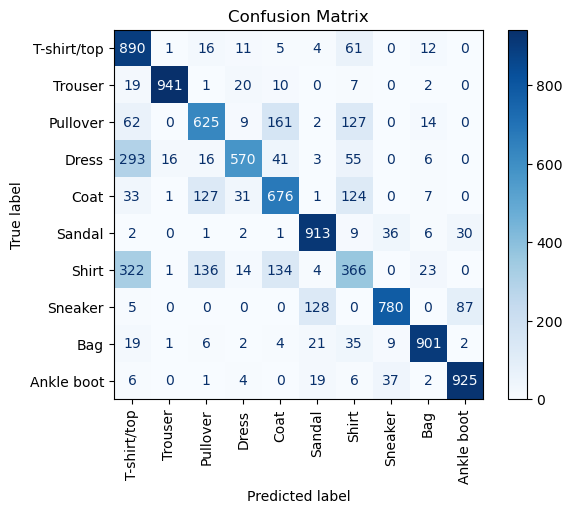

Custom CNN Model without MaxPooling:
Accuracy on test set: 10.01%


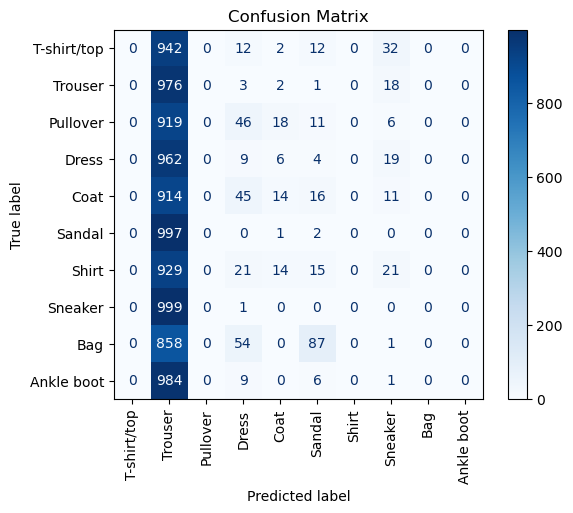

Built-in CNN Model:
Accuracy on test set: 76.48%


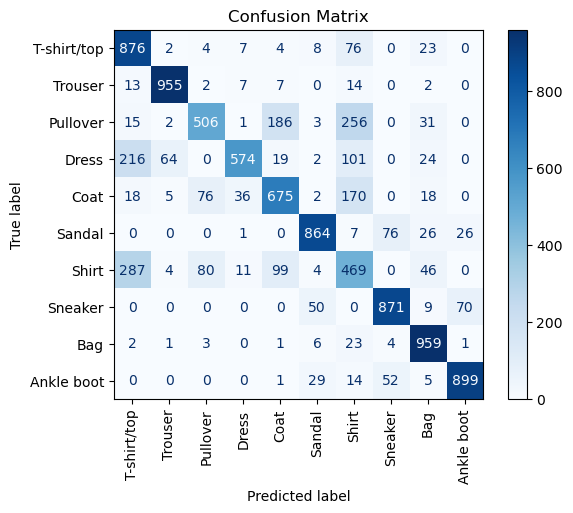

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to evaluate the model's performance on the test dataset
# It computes accuracy and returns the true and predicted labels for confusion matrix
def evaluate(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    correct = 0   # Counter for correctly classified samples
    total = 0     # Total number of samples in the test dataset
    label_true = []  # List to store true labels
    label_pred = []  # List to store predicted labels
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:  # Loop through test dataset
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the selected device (CPU/GPU)
            outputs = model(inputs)  # Get model outputs (predictions)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with the highest score
            total += labels.size(0)  # Increment total samples count
            correct += (predicted == labels).sum().item()  # Count correct predictions
            label_true.extend(labels.cpu().numpy())  # Collect true labels (convert from tensors to numpy)
            label_pred.extend(predicted.cpu().numpy())  # Collect predicted labels (convert from tensors to numpy)

    # Calculate accuracy as a percentage
    accuracy = 100 * correct / total
    print(f'Accuracy on test set: {accuracy:.2f}%')  # Print the accuracy

    return label_true, label_pred  # Return true and predicted labels for confusion matrix computation


# Function to plot the confusion matrix using true and predicted labels
def confusion_matrix_plot(label_true, label_pred, classes=test_dataset.classes):
    cm = confusion_matrix(label_true, label_pred)  # Compute the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)  # Create a display object for the matrix
    disp.plot(cmap=plt.cm.Blues)  # Plot the confusion matrix with a blue colormap
    plt.title('Confusion Matrix')  # Set plot title
    plt.xticks(rotation=90)  # Rotate x-axis labels to be readable
    plt.show()  # Show the plot


# Evaluate and plot for Custom CNN Model
print("Custom CNN Model:")
label_true, label_pred = evaluate(custom_model, test_loader, device)  # Evaluate the custom model
confusion_matrix_plot(label_true, label_pred)  # Plot confusion matrix for custom model

##################################################################
# Evaluate and plot for Custom CNN Model without MaxPooling

print("Custom CNN Model without MaxPooling:")
label_true, label_pred = evaluate(custom_model_no_maxpool, test_loader, device)  # Evaluate the custom model without MaxPooling
confusion_matrix_plot(label_true, label_pred)  # Plot confusion matrix for custom model without MaxPooling

# Evaluate and plot for Built-in CNN Model

print("Built-in CNN Model:")
label_true, label_pred = evaluate(built_in_model, test_loader, device)  # Evaluate the built-in model
confusion_matrix_plot(label_true, label_pred)  # Plot confusion matrix for built-in model